In [1]:
import torch
from torch import nn
import math
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
import altair as alt
import numpy as np
import pandas as pd

# Attention is all you need

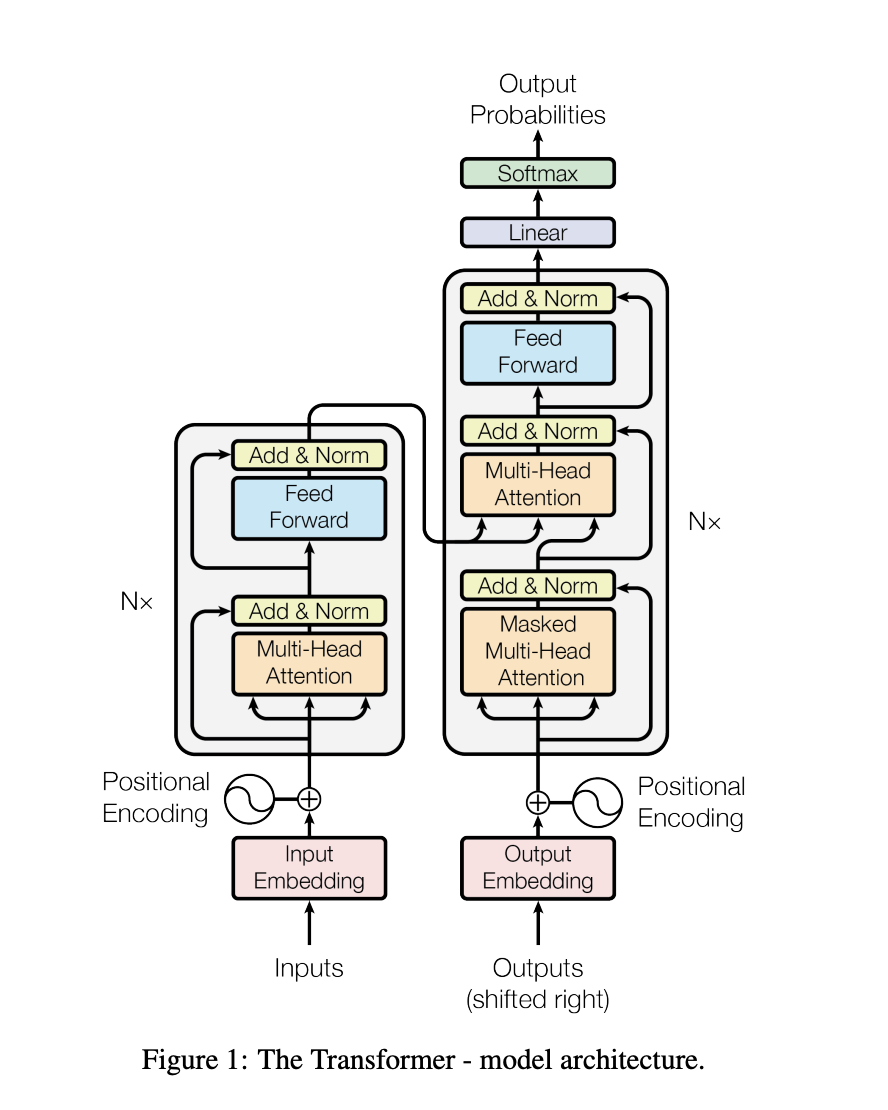

# Parameters and descriptions

- Vocab Size: all the tokens that can be part of the input sequence. sequences are tokenized based on the vocab
- Sequence Length: this is the length of the sentence or sequence fed into the tranformer
- Embedding Size: this is the size of the embedding for each node in the sequence above

S X E dimension for one sequence (S = d_model in the paper)

B X S X E for a batch size of B

From paper:

> To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

- Number of Heads: Number of heads in the attenion layer
- Head dimension: Can be calculated from embedding dimension and number of heads: embedding_size // num_heads (this is the same as d_k in the paper)


From paper:

> We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension d_k, and values of dimension d_v

Attention

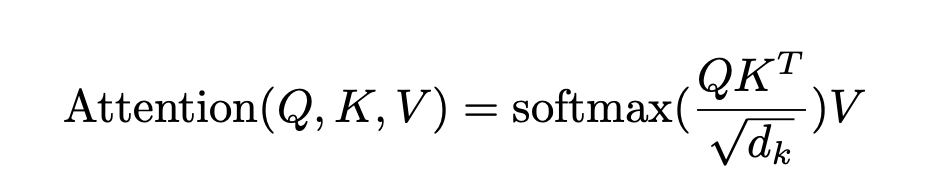

- Dropout: dropout rate after attention layer
- Feed Forward Hidden size: Hidden dimension for feed forward layer

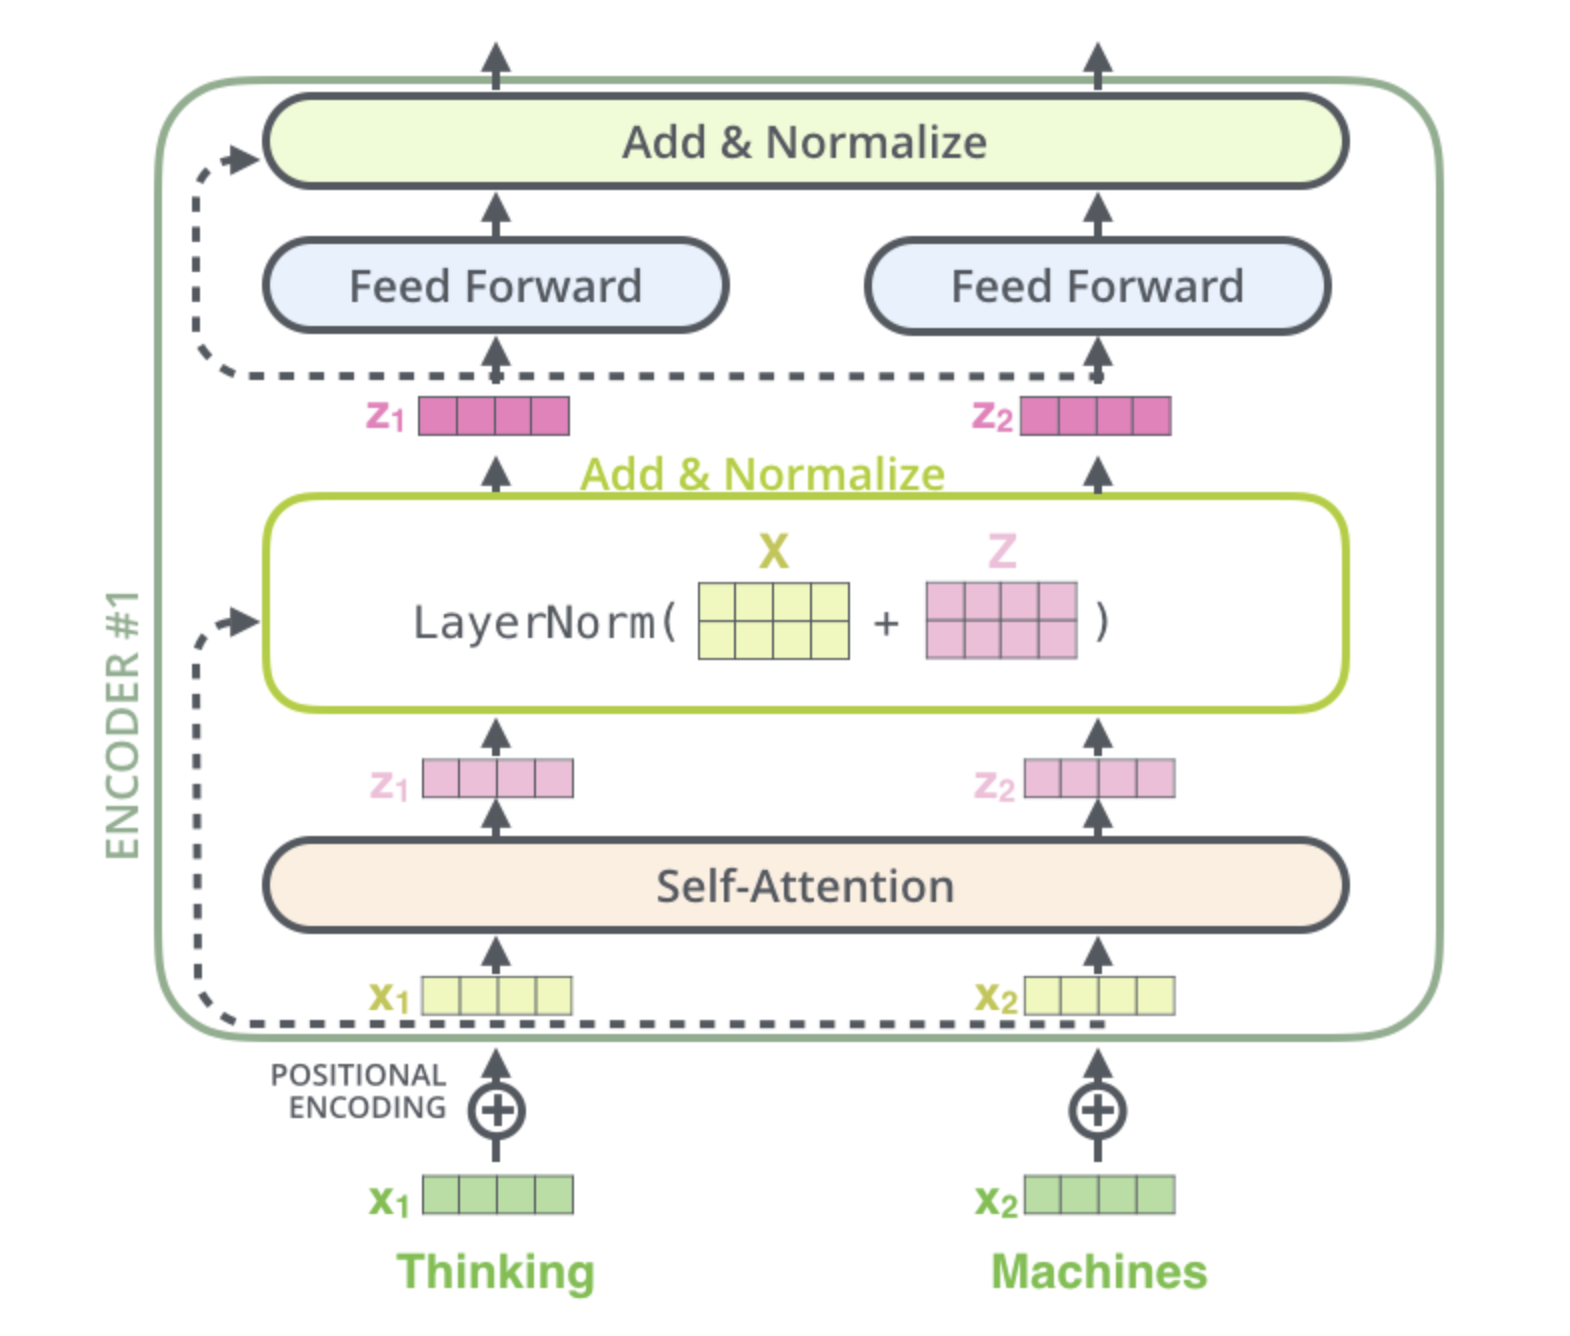

# Encoder

- Input -> Sparse Embedding
- X = Sparse Embedding + Position Embedding
- Calculate A_out = MultiHeadAttn(X)
- A_out = Dropout(A_out)
- L_out = LayerNorm(A_out + X)
- F_out = FeedForwardNN(L_out)
- F_out = Dropout(F_out)
- out = LayerNorm(F_out + L_out)

In [2]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Read the novel from the text file
with open('./data/1984.txt', 'r', encoding='utf-8') as file:
    novel_text = file.read()

/Users/kapilsharma/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
encoded_input = tokenizer(novel_text, return_tensors='pt')
encoded_input

Token indices sequence length is longer than the specified maximum sequence length for this model (141170 > 1024). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[14126,   352,   628,  ..., 10970, 23578,   198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [4]:
sequence_length = 10
batch_size = 4

In [5]:
model_inputs = encoded_input["input_ids"].ravel().unfold(0, sequence_length, 1).to(torch.int32)

In [6]:
model_inputs

tensor([[14126,   352,   628,  ...,   257,  6016,  4692],
        [  352,   628,   198,  ...,  6016,  4692,  1110],
        [  628,   198,   198,  ...,  4692,  1110,   287],
        ...,
        [ 2739,   257,  3128,  ...,   198,   198, 10970],
        [  257,  3128,   355,  ...,   198, 10970, 23578],
        [ 3128,   355, 32215,  ..., 10970, 23578,   198]], dtype=torch.int32)

In [7]:
batch = model_inputs[:batch_size, :]

In [8]:
batch

tensor([[14126,   352,   628,   198,   198,  1026,   373,   257,  6016,  4692],
        [  352,   628,   198,   198,  1026,   373,   257,  6016,  4692,  1110],
        [  628,   198,   198,  1026,   373,   257,  6016,  4692,  1110,   287],
        [  198,   198,  1026,   373,   257,  6016,  4692,  1110,   287,  3035]],
       dtype=torch.int32)

# Position Encoding

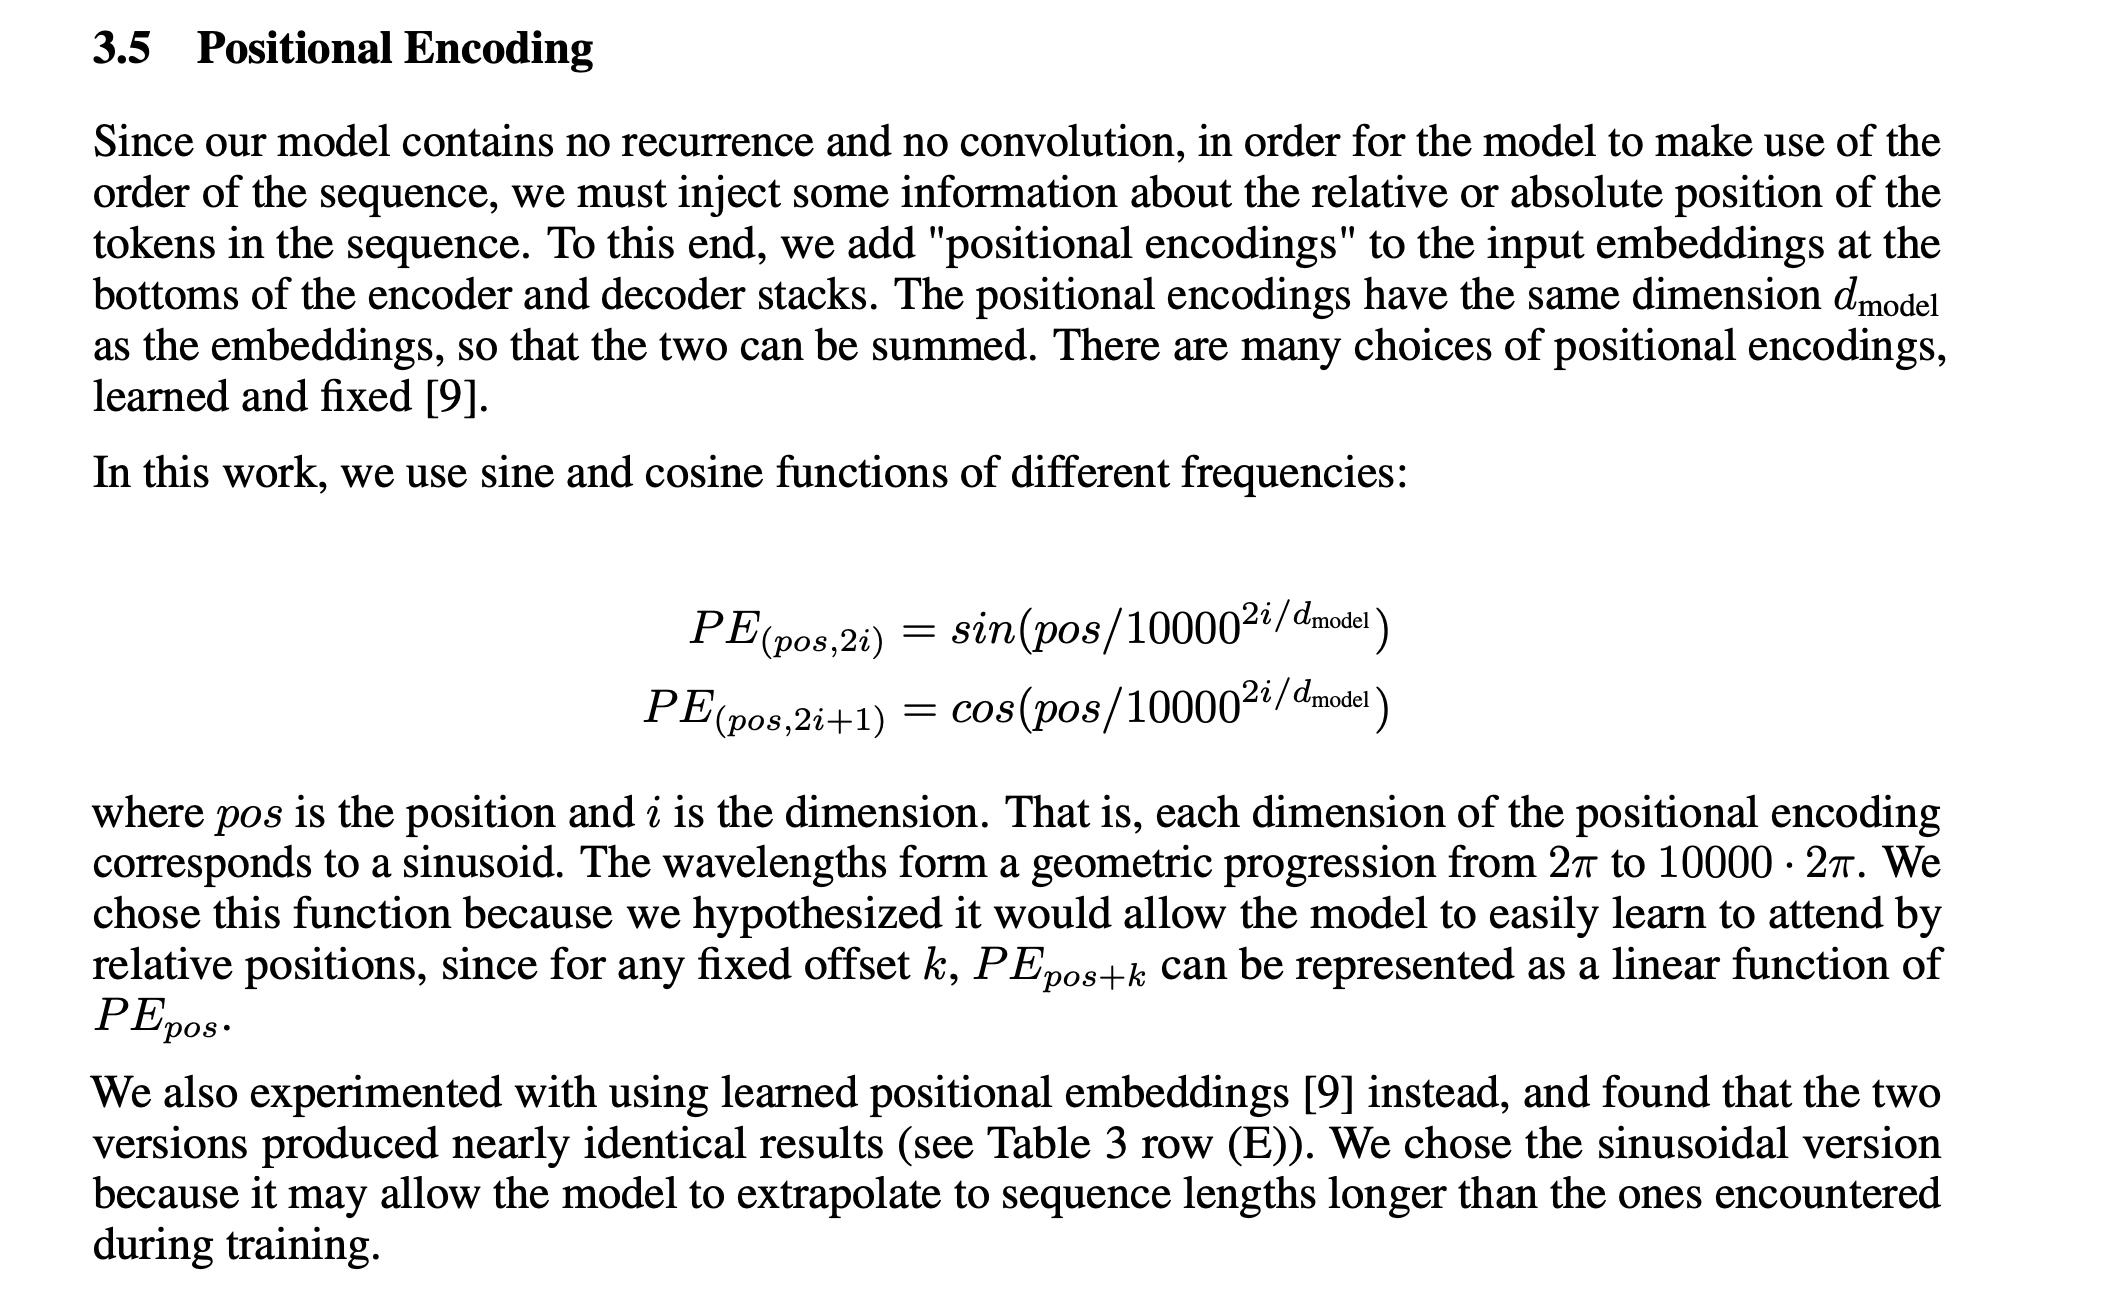

In [9]:
embedding_dimension = 6 # d_model

In [10]:
even_index = torch.arange(0, embedding_dimension, 2)
odd_index = torch.arange(1, embedding_dimension, 2)

In [11]:
even_index

tensor([0, 2, 4])

In [12]:
odd_index

tensor([1, 3, 5])

In [13]:
denominator = torch.pow(10000, even_index / embedding_dimension)
denominator # odd denominator is the same

tensor([  1.0000,  21.5443, 464.1590])

In [14]:
positions = torch.arange(0, sequence_length, 1).reshape(sequence_length, 1)
positions

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [15]:
even_pe = torch.sin(positions / denominator)
odd_pe = torch.cos(positions / denominator)

In [16]:
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [17]:
odd_pe

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [18]:
stacked = torch.stack([even_pe, odd_pe], dim=2)
position_embeddings = torch.flatten(stacked, start_dim=1, end_dim=2)

In [19]:
position_embeddings

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

In [20]:
# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(sequence_length), range(embedding_dimension))

# Convert this grid to columnar data expected by Altair
source = pd.DataFrame({'sequence_index': x.ravel(),
                     'embedding_index': y.ravel(),
                     'position_embeddings': position_embeddings.ravel()})

alt.Chart(source).mark_rect().encode(
    x='sequence_index:O',
    y='embedding_index:O',
    color='position_embeddings:Q'
)

alt.Chart(...)

# Input Layer

In [21]:
class InputLayer(nn.Module):
    def __init__(self, 
                 num_embeddings: int, 
                 sequence_length: int, 
                 embedding_dimension: int):
        super().__init__()
        self.sequence_length = sequence_length
        self.embedding_dimension = embedding_dimension
        self.input_embeddings = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_dimension)
        self.position_embeddings = self._init_position_embedding(sequence_length, embedding_dimension)
        print(sequence_length, embedding_dimension)

    @staticmethod
    def _init_position_embedding(sl: int, ed: int) -> torch.Tensor:
        even_index = torch.arange(0, embedding_dimension, 2)
        odd_index = torch.arange(1, embedding_dimension, 2)
        denominator = torch.pow(10000, even_index / embedding_dimension)
        even_pe = torch.sin(positions / denominator)
        odd_pe = torch.cos(positions / denominator)
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        return torch.flatten(stacked, start_dim=1, end_dim=2)
        
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        emb = self.input_embeddings(input)
        return emb + self.position_embeddings

In [22]:
input_layer = InputLayer(num_embeddings=len(tokenizer.get_vocab()), sequence_length=sequence_length, embedding_dimension=embedding_dimension)

10 6


In [23]:
input_layer

InputLayer(
  (input_embeddings): Embedding(50257, 6)
)

In [24]:
attention_input = input_layer(batch)

In [25]:
attention_input.size()

torch.Size([4, 10, 6])

In [26]:
attention_input

tensor([[[ 2.9680e-01,  9.5327e-02, -1.9793e+00,  3.1227e-01, -1.5255e+00,
          -9.3067e-01],
         [ 1.0555e+00, -4.2110e-01,  1.3615e+00,  2.2269e+00, -2.8203e-01,
          -5.6523e-01],
         [ 1.5332e+00, -1.5654e-01, -3.4263e-01,  3.0730e-01,  1.6700e+00,
           1.1845e+00],
         [ 3.0192e-01,  5.5138e-01,  1.0370e+00,  2.9790e-01, -1.5809e+00,
           2.4687e-01],
         [-5.9601e-01,  8.8773e-01,  1.0828e+00,  2.9039e-01, -1.5787e+00,
           2.4685e-01],
         [-2.4827e-01,  4.8362e-01,  2.0303e+00, -9.0179e-02,  7.8423e-01,
          -2.0421e-01],
         [-3.1593e-01, -1.9745e+00,  1.3553e+00, -1.3634e+00,  7.3837e-01,
           1.6534e+00],
         [ 3.4625e-01,  6.9935e-01,  4.6923e-01,  9.5425e-01, -2.7048e+00,
           5.3845e-01],
         [ 1.5570e+00, -9.4314e-02,  8.8683e-01,  5.6668e-01,  1.6668e+00,
           1.1191e+00],
         [-1.2813e+00, -1.2646e+00,  1.1507e+00,  2.1071e+00, -3.9759e-01,
          -4.5508e-01]],

        

# Multi Head Attention

In [27]:
num_heads = 2
head_dimension = embedding_dimension // num_heads
if embedding_dimension % num_heads != 0:
    raise ValueError("embedding_dimension should be divisible by num_heads")

In [28]:
# split up input into Q, K, V
qkv_layer = nn.Linear(embedding_dimension, 3 * embedding_dimension)
with torch.no_grad():
    qkv_layer.weight.fill_(2)

qkv = qkv_layer(attention_input)

In [29]:
qkv.size()

torch.Size([4, 10, 18])

In [30]:
input_shape = attention_input.shape
input_shape = input_shape[:-1] + (num_heads, 3 * head_dimension)
input_shape

torch.Size([4, 10, 2, 9])

In [31]:
qkv = qkv.reshape(*input_shape)
qkv = qkv.permute(0, 2, 1, 3)

In [32]:
qkv.size() # batch_size, num_head, sequence_length, 3 * head_dim

torch.Size([4, 2, 10, 9])

In [33]:
q, k, v = qkv.chunk(3, dim=-1)

In [34]:
for masked in [True, False]:
    if masked:
        mask = torch.full((sequence_length, sequence_length),
                          -torch.inf)
        mask = torch.triu(mask, diagonal=1)
    else:
        mask = torch.zeros((sequence_length, sequence_length))
    print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [

## Scaled Dot Product Attention

In [35]:
# here we take the query and key head blocks and do the scaled multiply

scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dimension)

# here we add the masks for backward looking bias (for encoder the masks are all 0 since we use both forward and backward context)
scores += mask

# softmax(QK/sqrt(d_model))
attention = torch.softmax(scores, dim=-1)

In [36]:
attention.size()

torch.Size([4, 2, 10, 10])

In [37]:
# last part in the attention calculation where we multiply with values
values = torch.matmul(attention, v)

In [38]:
values.size()

torch.Size([4, 2, 10, 3])

In [39]:
values = values.transpose(1, 2).contiguous()
print("After transposing the head and sequence dims", values.size())
values = values.view(*values.shape[:2], -1)
print("After concating all the head dims", values.size())

After transposing the head and sequence dims torch.Size([4, 10, 2, 3])
After concating all the head dims torch.Size([4, 10, 6])


In [40]:
# final linear layer in the attention

attn_linear_layer = nn.Linear(embedding_dimension, embedding_dimension)
attn_out = attn_linear_layer(values)
print("output from attention has size", attn_out.size())
attn_out

output from attention has size torch.Size([4, 10, 6])


tensor([[[  5.2424,  -2.7415,  -1.7799,  -3.7340,   8.0110,   0.4473],
         [ -8.3697,   3.7992,   1.8237,   5.0655, -12.3807,  -0.1476],
         [ -8.3697,   3.7992,   1.8237,   5.0655, -12.3807,  -0.1476],
         [ -8.3697,   3.7989,   1.8231,   5.0651, -12.3802,  -0.1477],
         [ -8.3790,   3.7125,   1.6486,   4.9694, -12.2063,  -0.1882],
         [ -8.3697,   3.7992,   1.8237,   5.0655, -12.3807,  -0.1476],
         [ -8.8538,   1.6641,  -2.6624,   2.7247,  -8.2101,  -1.2132],
         [ -8.3844,   3.6740,   1.5699,   4.9268, -12.1294,  -0.2065],
         [ -8.3697,   3.7992,   1.8237,   5.0655, -12.3807,  -0.1476],
         [ -0.5229,  -2.4836,  -5.1498,  -2.8229,   4.5694,  -0.9129]],

        [[ -9.1448,   4.1716,   2.0288,   5.5665, -13.5418,  -0.1814],
         [ -9.1448,   4.1716,   2.0288,   5.5665, -13.5418,  -0.1814],
         [ -9.1448,   4.1716,   2.0288,   5.5665, -13.5418,  -0.1814],
         [ -9.1446,   4.1705,   2.0267,   5.5652, -13.5394,  -0.1819],
    

In [41]:
attn_out.size()

torch.Size([4, 10, 6])

In [42]:
# Finally we can write the whole Multi Head Attention as:



# Layer Normalization

In [43]:
# there is already a layer norm implementation in pytorch

layer_norm = nn.LayerNorm(embedding_dimension)
layer_norm_out = layer_norm(attn_out + attention_input) # attention_input is the residual connection
layer_norm_out.size()

torch.Size([4, 10, 6])

In [44]:
layer_norm_out[:, :, 0]

tensor([[ 1.2538, -0.9019, -1.0084, -0.9185, -1.0145, -1.1257, -1.5852, -0.8599,
         -1.0208, -0.2074],
        [-0.9913, -1.0194, -0.8592, -0.9270, -1.0966,  0.2723,  1.4802, -1.0568,
         -1.0611,  1.2026],
        [-1.1107, -0.8488, -0.8377, -1.0070,  0.5534,  1.1136, -1.1597, -1.0999,
         -0.8557, -0.7429],
        [-0.9050, -0.7951, -0.8832,  0.7996,  1.1390, -1.2932, -1.2252, -0.8110,
         -0.5766,  1.2554]], grad_fn=<SelectBackward0>)

In [45]:
# let;s calculate it from scratch
attn_out_mean = attn_out.mean(-1, keepdim=True)
attn_out_var = torch.pow(attn_out - attn_out_mean, 2).mean(-1, keepdims=True)
attn_out_std = torch.sqrt(attn_out_var + layer_norm.eps)
ln_out = (attn_out - attn_out_mean) / attn_out_std
ln_out[:, :, 0]

tensor([[ 1.0054, -1.0343, -1.0343, -1.0343, -1.0447, -1.0343, -1.3693, -1.0495,
         -1.0343,  0.2332],
        [-1.0333, -1.0333, -1.0333, -1.0334, -1.0333,  0.9656,  0.9418, -1.0333,
         -1.0333,  0.9642],
        [-1.0347, -1.0347, -1.0347, -1.0347,  0.9897,  0.9894, -1.0347, -1.0347,
         -1.0744, -1.0347],
        [-1.0386, -1.0385, -1.0385,  0.9975,  0.9975, -1.0385, -1.0402, -1.0412,
         -1.0385,  0.9975]], grad_fn=<SelectBackward0>)

# Feed Forward Network

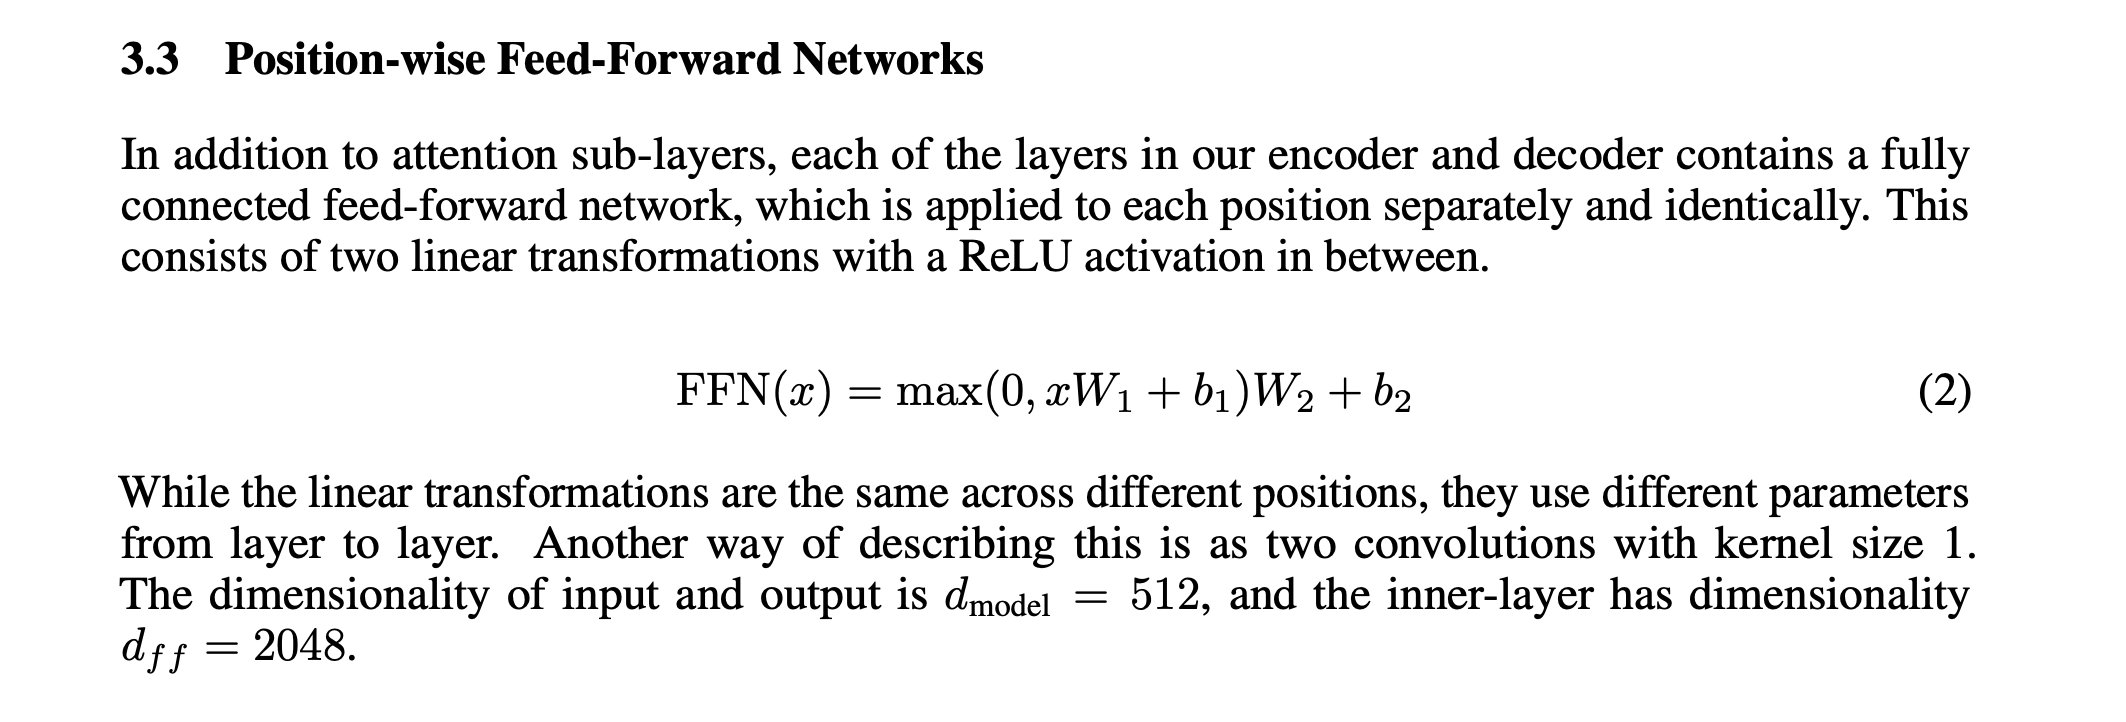

> The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
df f = 2048.

In [46]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, 
                 embedding_dimension: int, 
                 hidden_dimension: int, 
                 drop_prop: float):
        super().__init__()
        self.linear1 = nn.Linear(in_features=embedding_dimension, out_features=hidden_dimension)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(in_features=hidden_dimension, out_features=embedding_dimension)

    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

In [47]:
ffn_hidden_dimension = 12
dropout_prob = 0.1
ffn = FeedForwardNetwork(embedding_dimension=embedding_dimension, hidden_dimension=ffn_hidden_dimension, drop_prop=dropout_prob)

In [48]:
ffn_out = ffn(layer_norm_out)
ffn_out.size()

torch.Size([4, 10, 6])

At this point, ffn output also goes through a layer normalization

In [49]:
ffn_layer_norm = nn.LayerNorm(embedding_dimension)
ffn_layer_norm_out = ffn_layer_norm(ffn_out + layer_norm_out) # layer_norm_out is the residual connection
ffn_layer_norm_out.size()

torch.Size([4, 10, 6])

In [50]:
ffn_layer_norm_out

tensor([[[ 1.3362e+00, -4.7257e-01, -1.3751e+00, -7.8179e-01,  1.2180e+00,
           7.5282e-02],
         [-9.0413e-01,  3.1107e-01, -4.3772e-02,  1.6480e+00, -1.4691e+00,
           4.5791e-01],
         [-8.9025e-01,  3.8530e-01,  5.5891e-01,  1.3821e+00, -1.6681e+00,
           2.3195e-01],
         [-7.8685e-01,  4.4485e-01,  7.5485e-01,  1.2401e+00, -1.7509e+00,
           9.7970e-02],
         [-1.0283e+00,  3.8448e-01,  9.9134e-02,  1.4428e+00, -1.5214e+00,
           6.2329e-01],
         [-1.1391e+00,  4.8963e-01,  9.3104e-02,  1.4534e+00, -1.4332e+00,
           5.3614e-01],
         [-1.5671e+00,  1.1966e-01,  5.0335e-01,  1.2678e+00, -1.0610e+00,
           7.3720e-01],
         [-7.3634e-01,  5.8806e-01,  4.0254e-01,  1.3337e+00, -1.7713e+00,
           1.8341e-01],
         [-1.0103e+00,  2.6809e-01,  8.2387e-02,  1.5074e+00, -1.4890e+00,
           6.4143e-01],
         [ 4.2839e-02, -9.9886e-01, -1.0855e+00,  4.8776e-01,  1.8671e+00,
          -3.1329e-01]],

        

# Decoder

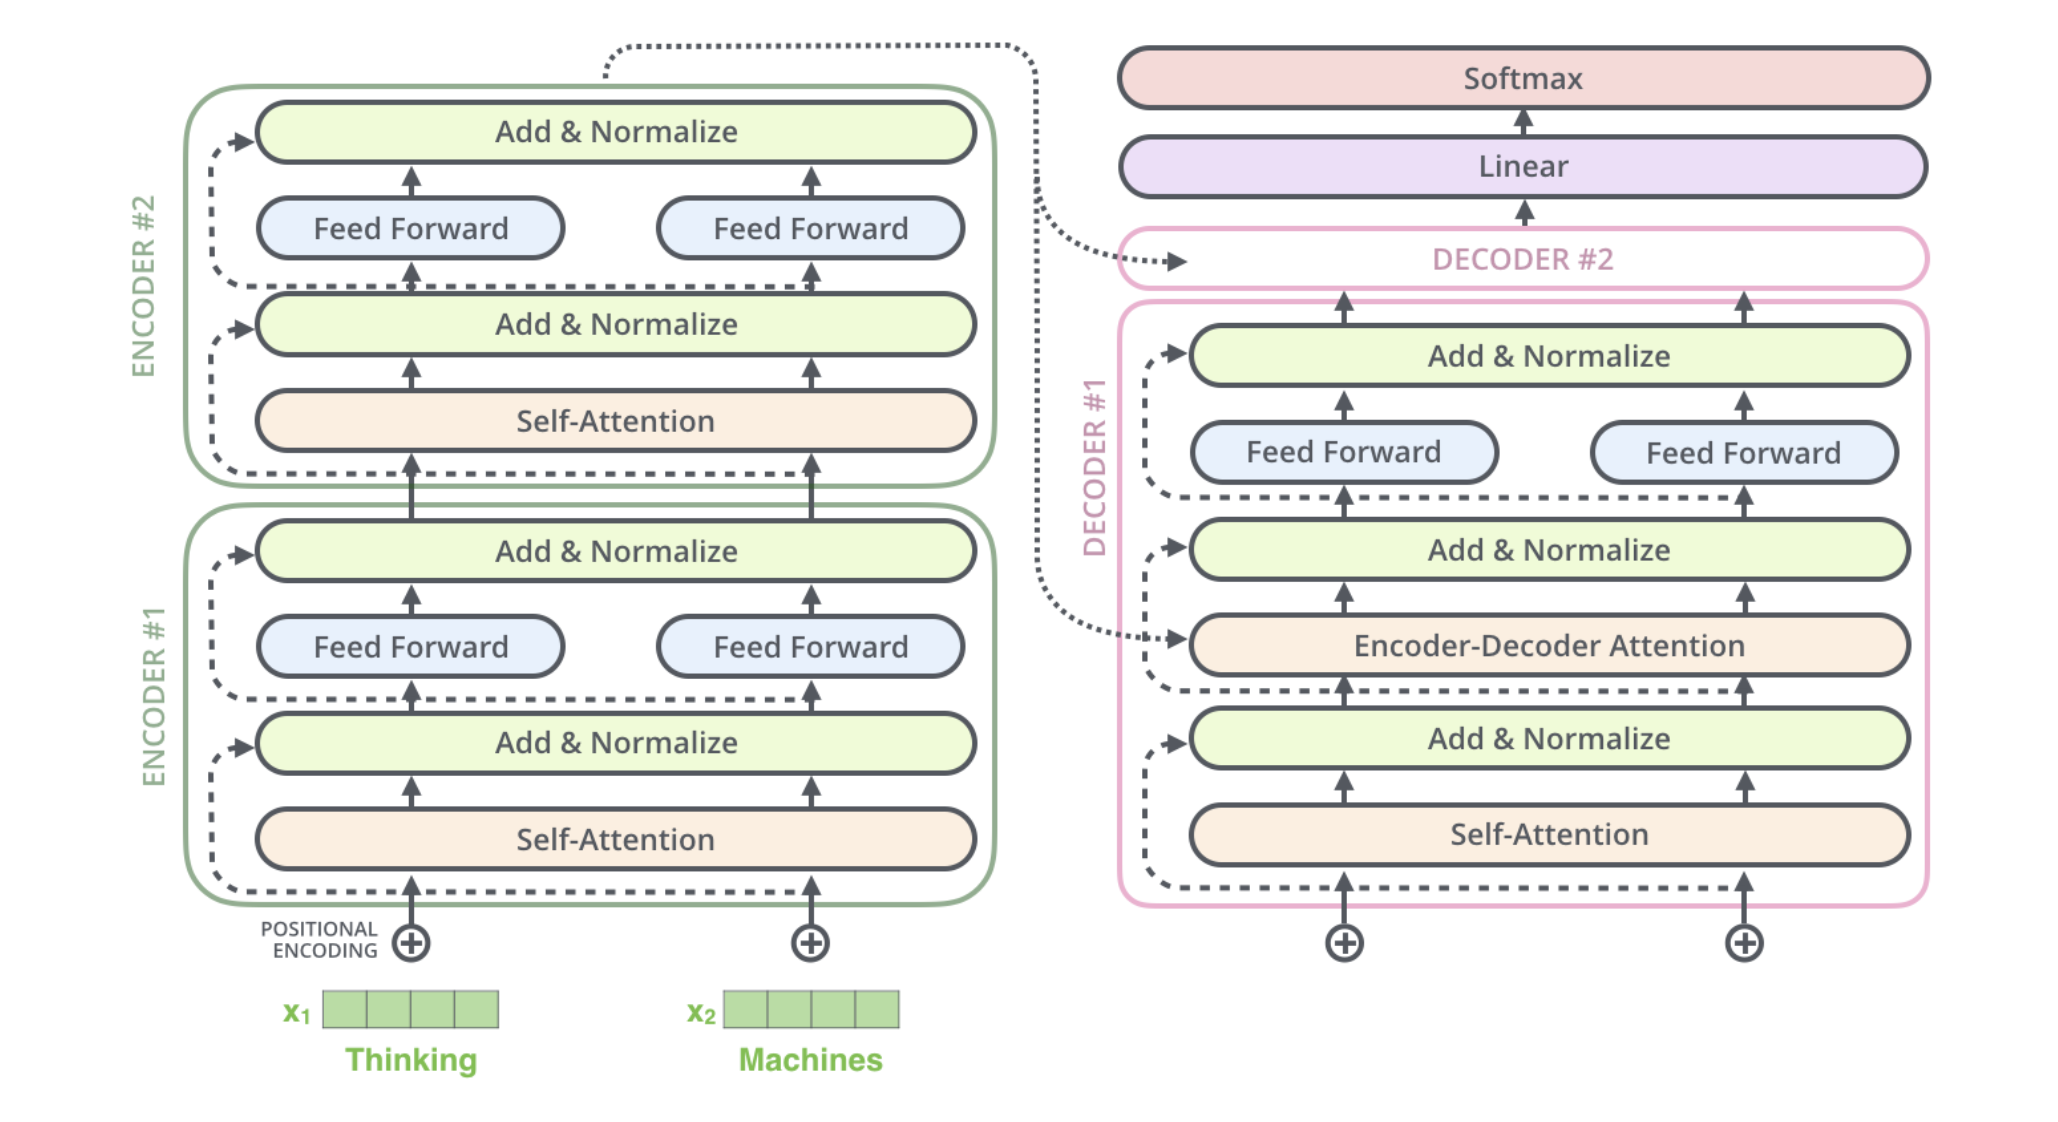

Here's the pseudo code for the decoder layer:

- **Input -> Sparse Embedding:** Embedding layer that converts tokens to embeddings
- **X = Sparse Embedding + Position Embedding (Masked):** Add position embeddings to token embeddings - this completes the input layer
- **Calculate A_out = MultiHeadAttn(X):**: Calculate multi-head attention output (this is self-attention i.e. similar to encoder but with masking)
- **A_out = Dropout(A_out):** Apply dropout to the multi-head attention output
- **L_out = LayerNorm(A_out + X):** : Add residual connection from input to the multi-head attention output and apply layer normalization
- **C_out = MultiHeadCrossAttn(L_out, encoder_out):** Cross attention with encoder output
- **C_out = Dropout(A_out):** Apply dropout to the cross attention output
- **LC_out = LayerNorm(C_out + L_out):** Add residual connection to output from cross attention + dropout and apply layer normalization
- **F_out = FeedForwardNN(LC_out):**: Pass the output from the multi-head attention through a feed forward network (similar to encoder)
- **F_out = Dropout(F_out):** Apply dropout to the feed forward network output
- **out = LayerNorm(F_out + LC_out):** Add residual connection from the multi-head attention output to the feed forward network output and apply layer normalization

Since, decoder processes inputs shifted by 1 and accounts for the start of text as being it's own token, we need to update our tokenizer to add this "start of text" token now. 

Based on the [GPT2 paper](https://arxiv.org/pdf/1901.05207), it was only trained with the endoftext token. So, we will use endoftext special token itself for the start of text token. There was a [helpful discussion](https://github.com/huggingface/transformers/issues/429#issue-427290740) on Github regarding this.

Here's an example of how we will use the `<|endoftext|>` token.

In [51]:
text = "<|endoftext|> machine learning using PyTorch"
encoded_ids = tokenizer.encode(text)
print(encoded_ids)
for id in encoded_ids:
    print(
        f"""{id:<7} = {"'" + tokenizer.convert_ids_to_tokens(id) + "":<10}'""")

[50256, 4572, 4673, 1262, 9485, 15884, 354]
50256   = '<|endoftext|>'
4572    = 'Ġmachine '
4673    = 'Ġlearning'
1262    = 'Ġusing   '
9485    = 'ĠPy      '
15884   = 'Tor      '
354     = 'ch       '


Let's add the `<|endoftext|>` token to the original encoded inputs to generate the decoder input

In [52]:
print("encoder input: ", encoded_input["input_ids"][:, :10])
print("decoder_input: ", torch.cat(
    (torch.Tensor([[tokenizer.convert_tokens_to_ids("<|endoftext|>")]]), 
     encoded_input["input_ids"]), 
    dim=-1)[:, :10])

encoder input:  tensor([[14126,   352,   628,   198,   198,  1026,   373,   257,  6016,  4692]])
decoder_input:  tensor([[50256., 14126.,   352.,   628.,   198.,   198.,  1026.,   373.,   257.,
          6016.]])


In [53]:
batch_size = 4

decoder_input = torch.cat((torch.Tensor([[tokenizer.convert_tokens_to_ids("<|endoftext|>")]]),  encoded_input["input_ids"]), dim=-1).to(torch.int32)
model_inputs = decoder_input.ravel().unfold(0, sequence_length, 1).to(torch.int32)
decoder_batch = model_inputs[:4, :]
print(decoder_batch)

tensor([[50256, 14126,   352,   628,   198,   198,  1026,   373,   257,  6016],
        [14126,   352,   628,   198,   198,  1026,   373,   257,  6016,  4692],
        [  352,   628,   198,   198,  1026,   373,   257,  6016,  4692,  1110],
        [  628,   198,   198,  1026,   373,   257,  6016,  4692,  1110,   287]],
       dtype=torch.int32)


Awesome, now let's feed this input throught the decoder layers

## Decoder Input Layer

In [54]:
decoder_input_layer = InputLayer(num_embeddings=len(tokenizer.get_vocab()), sequence_length=sequence_length, embedding_dimension=embedding_dimension)
decoder_attention_input = decoder_input_layer(decoder_batch)
print("decoder attention input size:", decoder_attention_input.size())
print(decoder_attention_input[:2, :2]) # let's print a small portion of the embeddings

10 6
decoder attention input size: torch.Size([4, 10, 6])
tensor([[[-1.5678,  0.8977,  1.1340,  1.3347, -0.0344,  1.0387],
         [ 1.0382,  0.4510, -0.0422,  1.3403,  0.3063,  3.0427]],

        [[ 0.1967,  0.9107, -0.0886,  1.3414,  0.3041,  3.0427],
         [ 1.2427,  2.1347,  0.4189, -1.0451, -0.0654,  2.1635]]],
       grad_fn=<SliceBackward0>)


## Decoder Self Attention Layer

Based on our exploration in encoder section, we can define a proper module for `ScaledDotProductAttention` and `MultHeadAttention`. Let's do that first.

In [55]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, sequence_length: int, d_k: int, masked: bool) -> None:
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        if masked:
            mask = torch.full((sequence_length, sequence_length),
                              -torch.inf)
            self.mask = torch.triu(mask, diagonal=1)
        else:
            self.mask = torch.zeros((sequence_length, sequence_length))

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        scores += self.mask
        attention = F.softmax(scores, dim=-1)
        return torch.matmul(attention, v), attention

In [56]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dimension: int, sequence_length: int,
                 num_heads: int, masked: bool = False) -> None:
        super(MultiHeadAttention, self).__init__()
        self.head_dimension = embedding_dimension // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(embedding_dimension, embedding_dimension)
        self.k_linear = nn.Linear(embedding_dimension, embedding_dimension)
        self.v_linear = nn.Linear(embedding_dimension, embedding_dimension)
        self.out = nn.Linear(embedding_dimension, embedding_dimension)
        self.attention_layer = ScaledDotProductAttention(
            sequence_length=sequence_length,
            d_k=self.head_dimension,
            masked=masked
        )

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        # q, k, v have shape (batch_size, sequence_length, embedding_dimension)
        # next we apply the linear layer and then split the output into
        # num_heads
        batch_size = q.size(0)
        # second dimension is the sequence length
        output_shape = (batch_size, -1, self.num_heads, self.head_dimension)
        # we transpose the output to
        # (batch_size, num_heads, sequence_length, head_dimension)
        # this allows us to use num_heads as a batch dimension
        q = self.q_linear(q).view(*output_shape).transpose(1, 2)
        k = self.k_linear(k).view(*output_shape).transpose(1, 2)
        v = self.v_linear(v).view(*output_shape).transpose(1, 2)
        # we apply the scaled dot product attention
        x, attention = self.attention_layer(q, k, v)
        # we transpose the output back to
        # (batch_size, sequence_length, embedding_dimension)
        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.head_dimension * self.num_heads)
        return self.out(x), attention

Now, we can use these to first calculate the Causal Self Attention Block.

![Masked Multi Head Attention Block](./masked_MHA.png)

We will combine the steps where attention output is fed into LayerNorm to get final input to the cross attention block.

In [57]:
def calculate_causal_mha_layer(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    causal_mha = MultiHeadAttention(embedding_dimension=embedding_dimension, sequence_length=sequence_length, num_heads=num_heads, masked=True)
    scores, _ = causal_mha(q, k, v) # we ignore the attention weights
    # we add a dropout layer
    dropout = nn.Dropout(dropout_prob)
    scores = dropout(scores)
    # calculate the layer norm
    layer_norm = nn.LayerNorm(embedding_dimension)
    return layer_norm(scores + q)


In [58]:
causal_mha_out = calculate_causal_mha_layer(decoder_attention_input, decoder_attention_input, decoder_attention_input)
print("causal mha out size:", causal_mha_out.size())

causal mha out size: torch.Size([4, 10, 6])


## Decoder Cross Attention Layer

Now that we have fed the inputs through the self attention layer, we can calculate the Cross Attention with the encoder output.

![Masked Cross Attention](./cross_attn.png)

In [59]:
# let's calculate the cross attention with the encoder output


def calculate_cross_attention_layer(self_attention_output: torch.Tensor, encoder_output: torch.Tensor) -> torch.Tensor:
    cross_attention = MultiHeadAttention(embedding_dimension=embedding_dimension, sequence_length=sequence_length, num_heads=num_heads, masked=False)
    # we replace the Q with the encoder output, K and V are the self_attention_output in the decoder
    scores, _ = cross_attention(q=encoder_output, k=self_attention_output, v=self_attention_output) # we ignore the attention weights
    # we add a dropout layer
    dropout = nn.Dropout(dropout_prob)
    scores = dropout(scores)
    # calculate the layer norm
    layer_norm = nn.LayerNorm(embedding_dimension)
    return layer_norm(scores + self_attention_output)

encoder_output = ffn_layer_norm_out
cross_attention_output = calculate_cross_attention_layer(causal_mha_out, encoder_output)
print("cross attention output size:", cross_attention_output.size())
print(cross_attention_output[:2, :2])

cross attention output size: torch.Size([4, 10, 6])
tensor([[[-1.4696, -0.2281,  0.9616,  1.2115, -1.0386,  0.5631],
         [ 0.4103, -0.9369, -0.4824,  0.4833, -1.2118,  1.7376]],

        [[-0.0984, -0.9770, -0.4532,  0.9048, -1.0696,  1.6934],
         [ 0.5928,  0.2521, -0.2467, -0.6021, -1.6045,  1.6084]]],
       grad_fn=<SliceBackward0>)


# Decoder Feed Forward Layer

Now, we can calculate the feed forward layer just like the encoder part of the network. 

In [60]:
def calculate_ffn_layer(cross_attention_output: torch.Tensor) -> torch.Tensor:
    ffn = FeedForwardNetwork(embedding_dimension=embedding_dimension, hidden_dimension=ffn_hidden_dimension, drop_prop=dropout_prob)
    ffn_out = ffn(cross_attention_output)
    # no dropout since it is already applied in the FeedForwardNetwork
    ffn_layer_norm = nn.LayerNorm(embedding_dimension)
    return ffn_layer_norm(ffn_out + cross_attention_output) # cross_attention_output is the residual connection

ffn_output = calculate_ffn_layer(cross_attention_output)
print("ffn output size:", ffn_output.size())
print(ffn_output[:2, :2])

ffn output size: torch.Size([4, 10, 6])
tensor([[[-0.4656, -1.0808,  1.0333,  1.6432, -0.8880, -0.2421],
         [ 0.7643, -0.8035, -0.8962,  1.0756, -1.2534,  1.1132]],

        [[ 0.0435, -1.0044, -0.6330,  1.0462, -1.0192,  1.5669],
         [ 1.1781,  0.4439, -0.9004,  0.2974, -1.7335,  0.7147]]],
       grad_fn=<SliceBackward0>)


## Output Probabilities

Final layer of the network calculates the probabilities for the output token from the network. In this layer, we pass the normalized output from FeedForward layer to Linear + Softmax. 

![Output Layer](./output_layer.png)

In [61]:
def calculate_output_probabilities(ffn_output: torch.Tensor) -> torch.Tensor:
    # output dimension for linear layer is the vocab size
    output_linear = nn.Linear(embedding_dimension, len(tokenizer.get_vocab())) 
    return F.softmax(output_linear(ffn_output), dim=-1) # final output probabilities

output_probabilities = calculate_output_probabilities(ffn_output)
print("output probabilities size:", output_probabilities.size())
print(output_probabilities)

output probabilities size: torch.Size([4, 10, 50257])
tensor([[[3.1212e-05, 1.0280e-05, 1.6740e-05,  ..., 3.1254e-05,
          7.0752e-06, 2.4604e-05],
         [5.9005e-05, 1.8654e-05, 3.1722e-05,  ..., 1.7084e-05,
          1.3529e-05, 8.2879e-06],
         [5.3975e-05, 1.2286e-05, 2.2306e-05,  ..., 1.3980e-05,
          1.5624e-05, 1.4072e-05],
         ...,
         [1.9923e-05, 2.8610e-05, 3.4684e-05,  ..., 2.0025e-05,
          4.1697e-05, 3.8417e-06],
         [3.9923e-05, 1.7508e-05, 2.8279e-05,  ..., 2.3878e-05,
          9.8570e-06, 7.9356e-06],
         [2.5231e-05, 1.0597e-05, 1.7633e-05,  ..., 2.6316e-05,
          7.3367e-06, 1.0928e-05]],

        [[5.1926e-05, 1.3585e-05, 2.9657e-05,  ..., 1.5079e-05,
          1.6004e-05, 1.0349e-05],
         [6.8143e-05, 2.4282e-05, 3.0731e-05,  ..., 1.6185e-05,
          1.8971e-05, 9.9972e-06],
         [3.9091e-05, 1.3111e-05, 2.5424e-05,  ..., 2.0407e-05,
          1.0169e-05, 9.3211e-06],
         ...,
         [5.1102e-05, 2.5

We finally have the seq2seq probabilities.

## Decoder Summary

In the decoder section, we have described the different layers and operations involved in the decoder of a neural network. We have discussed the self-attention layer, cross-attention layer, feed-forward layer, and the output probabilities layer. We have also provided code examples and explanations for each layer.

The self-attention layer calculates the attention weights for each token in the input sequence based on its relationship with other tokens. The cross-attention layer performs attention over the encoder output to incorporate information from the input sequence. The feed-forward layer applies a non-linear transformation to the output of the cross-attention layer. Finally, the output probabilities layer calculates the probabilities for each token in the vocabulary.

The decoder plays a crucial role in tasks such as language translation, text generation, and sequence-to-sequence modeling.

> What are the top decoder only models?
> Most of the well known models are decoder only models:
> GPT
> LLAMA
> Gemini
> List goes on...

# Summary

We have discussed and implemented both the encoder and decoder parts of the transformers architecture from scratch. We have analyzed how the input tokens flow through the original transformers architecture and explained the different layers and operations involved in each part.

For the encoder, we have described the self-attention layer and feed-forward layer. We have provided code examples and explanations for each layer, including the calculation of attention weights , layer normalization, etc.

Similarly, for the decoder, we have discussed the self-attention layer, cross-attention layer, feed-forward layer, and the output probabilities layer. We have explained how the decoder incorporates information from the encoder output and generates output probabilities based on the input sequence.

This was generally a very fruitful exercise for me. This serves as a foundational exercise to understand all major transformer models.

To finish up, here is a really cool graphic that shows a list of major transformers based models from Sebastian Raschka's substacl post - [Understanding Encoder And Decoder LLMs](https://magazine.sebastianraschka.com/p/understanding-encoder-and-decoder).

![Transformers Evolution](./transformer_evolution.png)